# Setup

In [1]:
# Extract and build the benchmark
!rm -f ipc/ipc-static
!rm -f ipc/ipc-dynamic
!make -C ipc
!sysctl kern.ipc.maxsockbuf=33554432

cc -DWITH_PMC -Wall -o ipc-static -DPROGNAME=\"ipc-static\" ipc.c -static  -lpmc -lpthread
cc -DWITH_PMC -Wall -o ipc-dynamic -DPROGNAME=\"ipc-dynamic\" ipc.c -dynamic  -lpmc -lpthread
kern.ipc.maxsockbuf: 33554432 -> 33554432


In [2]:
# D Language scripts
D_ = """"""

In [3]:
import itertools
import re

def strs_to_tup(strs):
    if len(strs) == 1:
        return (strs[0].strip(),None)
    else:
        return (strs[0].strip(),strs[1].strip())

def flatten(lst):
    return list(itertools.chain.from_iterable(lst))

def parse(cmd_out):
    tups = map(strs_to_tup, [string.split(":") for string in cmd_out])
    return dict(tups)

def genfilename(exe, mode, ipc, runs, flags, suffix="", extension = "png"):
    return "{}_{}_{}_runs_{}_{}{}.{}".format(re.sub(r'[/-]', r'_', exe), mode, ipc, runs, re.sub(r'\s*-', r'', flags), suffix, extension)

def merge_two_dicts(x, y):
    z = x.copy()
    z.update(y)
    return z

def gather_pmc_vals(table, data, pmc):
    if pmc == "mem":
        table['instrs'] = [float(item["INSTR_EXECUTED"]) for item in data]
        table['cycles'] = [float(item["CLOCK_CYCLES"]) for item in data]
        table['cycles_per_instr'] = [float(item["CLOCK_CYCLES/INSTR_EXECUTED"]) for item in data]
        table['mem_read'] = [float(item["MEM_READ"]) for item in data]
        table['mem_read_per_cycle'] = [float(item["MEM_READ/CLOCK_CYCLES"]) for item in data]
        table['mem_read_per_instr'] = [float(item["MEM_READ/INSTR_EXECUTED"]) for item in data]
        table['mem_write'] = [float(item["MEM_WRITE"]) for item in data]
        table['mem_write_per_cycle'] = [float(item["MEM_WRITE/CLOCK_CYCLES"]) for item in data]
        table['mem_write_per_instr'] = [float(item["MEM_WRITE/INSTR_EXECUTED"]) for item in data]
    elif pmc == "l1d":
        table['instrs'] = [float(item["INSTR_EXECUTED"]) for item in data]
        table['cycles'] = [float(item["CLOCK_CYCLES"]) for item in data]
        table['cycles_per_instr'] = [float(item["CLOCK_CYCLES/INSTR_EXECUTED"]) for item in data]
        table['l1d_hits'] = [float(item["L1_DCACHE_ACCESS"]) for item in data]
        table['l1d_hits_per_instr'] = [float(item["L1_DCACHE_ACCESS/INSTR_EXECUTED"]) for item in data]
        table['l1d_hits_per_cycle'] = [float(item["L1_DCACHE_ACCESS/CLOCK_CYCLES"]) for item in data]
        table['l1d_refill'] = [float(item["L1_DCACHE_REFILL"]) for item in data]
        table['l1d_refill_per_instr'] = [float(item["L1_DCACHE_REFILL/INSTR_EXECUTED"]) for item in data]
        table['l1d_refill_per_cycle'] = [float(item["L1_DCACHE_REFILL/CLOCK_CYCLES"]) for item in data]
    elif pmc == "l1i":
        table['instrs'] = [float(item["INSTR_EXECUTED"]) for item in data]
        table['cycles'] = [float(item["CLOCK_CYCLES"]) for item in data]
        table['cycles_per_instr'] = [float(item["CLOCK_CYCLES/INSTR_EXECUTED"]) for item in data]
        table['l1i_refill'] = [float(item["L1_ICACHE_REFILL"]) for item in data]
        table['l1i_refill_per_instr'] = [float(item["L1_ICACHE_REFILL/INSTR_EXECUTED"]) for item in data]
        table['l1i_refill_per_cycle'] = [float(item["L1_ICACHE_REFILL/CLOCK_CYCLES"]) for item in data]
    elif pmc == "l2":
        table['instrs'] = [float(item["INSTR_EXECUTED"]) for item in data]
        table['cycles'] = [float(item["CLOCK_CYCLES"]) for item in data]
        table['cycles_per_instr'] = [float(item["CLOCK_CYCLES/INSTR_EXECUTED"]) for item in data]
        table['l2_hit'] = [float(item["L2_ACCESS"]) for item in data]
        table['l2_hit_per_instr'] = [float(item["L2_ACCESS/INSTR_EXECUTED"]) for item in data]
        table['l2_hit_per_cycle'] = [float(item["L2_ACCESS/CLOCK_CYCLES"]) for item in data]
    elif pmc == "axi":
        table['instrs'] = [float(item["INSTR_EXECUTED"]) for item in data]
        table['cycles'] = [float(item["CLOCK_CYCLES"]) for item in data]
        table['cycles_per_instr'] = [float(item["CLOCK_CYCLES/INSTR_EXECUTED"]) for item in data]
        table['axi_read'] = [float(item["AXI_READ"]) for item in data]
        table['axi_read_per_instr'] = [float(item["AXI_READ/INSTR_EXECUTED"]) for item in data]
        table['axi_read_per_cycle'] = [float(item["AXI_READ/CLOCK_CYCLES"]) for item in data]
        table['axi_write'] = [float(item["AXI_WRITE"]) for item in data]
        table['axi_write_per_instr'] = [float(item["AXI_WRITE/INSTR_EXECUTED"]) for item in data]
        table['axi_write_per_cycle'] = [float(item["AXI_WRITE/CLOCK_CYCLES"]) for item in data]
    elif pmc == "tlb":
        table['instrs'] = [float(item["INSTR_EXECUTED"]) for item in data]
        table['cycles'] = [float(item["CLOCK_CYCLES"]) for item in data]
        table['cycles_per_instr'] = [float(item["CLOCK_CYCLES/INSTR_EXECUTED"]) for item in data]
        table['itlb_refill'] = [float(item["ITLB_REFILL"]) for item in data]
        table['itlb_refill_per_instr'] = [float(item["ITLB_REFILL/INSTR_EXECUTED"]) for item in data]
        table['itlb_refill_per_cycle'] = [float(item["ITLB_REFILL/CLOCK_CYCLES"]) for item in data]
        table['dtlb_refill'] = [float(item["DTLB_REFILL"]) for item in data]
        table['dtlb_refill_per_instr'] = [float(item["DTLB_REFILL/INSTR_EXECUTED"]) for item in data]
        table['dtlb_refill_per_cycle'] = [float(item["DTLB_REFILL/CLOCK_CYCLES"]) for item in data]
    else:
        raise ValueError("Wrong pmc type: {}".format(pmc))
    return table

import time
from __future__ import print_function
from decimal import Decimal
import pandas as pd
import numpy as np
%matplotlib inline
# import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')

def label_points(x, y, ax):
    a = pd.concat({'x': x, 'y': y}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], "{:.2E}".format(Decimal(point['x'])))

def graph(xs, ys, num_trials = 0, save = False, save_name = "plot", title = None, xlabel = None, ylabel = None, label = None, axis = None):
    xvalues = np.reshape(ys, (len(xs), num_trials))[:,:]
    df = pd.DataFrame(xvalues, index=xs)
    error_bars = df.quantile([.25, .75], axis=1)
    error_bars.loc[[0.25]] = df.median(1) - error_bars.loc[[0.25]]
    error_bars.loc[[0.75]] = error_bars.loc[[0.75]] - df.median(1)
    error_bars_values = [error_bars.values]
    if axis:
        ax = df.median(1).plot(figsize=(9,9), yerr=error_bars_values, title=title, ax=axis)
    else:
        ax = df.median(1).plot(figsize=(9,9), yerr=error_bars_values, title=title)
    
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if label:
        ax.set_label(label)
    if title:
        ax.set_title(title)
    # ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xticks(df.index)
    ax.set_xticklabels(xs, rotation=45)
    plt.grid('on', axis='x' )
    plt.grid('on', axis='y' )
    if save:
        ax.get_figure().savefig("{}".format(save_name))
    return ax

def benchmark(flags, repeat, exe, mode, ipc, buf_sizes, tot_sizes, dtrace_info = None, bench_name = "", pmc = None ):
    runs = range(1, repeat + 1)
    outputs = []
    print("\t ==> Running {}".format(exe))
    print("\t\t ==> {} across {}".format(ipc, mode))
    is_dtrace = (dtrace_info != None)
    dtrace_thread = None
    verbose = "-v" in flags
    pmc_enabled = pmc is not None

    for buffer_size in buf_sizes:
        for tot_size in tot_sizes:
            cmd = "{} {} -i {} -b {} -t {} {}".format(exe, flags, ipc, buffer_size, tot_size, mode)

            discard = !{cmd} # Discard first benchmark run which may be biased
            results = []
            for i in runs:
                out = !{cmd}
                parsed = parse(out)
                results.append(parsed)

            times = [float(item['time']) for item in results] if verbose else None
            avg_time = sum(times) / len(runs) if verbose else None

            speeds = [float(item['speed'].split(' ')[0]) for item in results] # Need to split by ' ' because output speed has units attached to it (see ipc.c)
            avg_speed = sum(speeds) / len(runs)
            print("\t\t\t{0:2} bytes {1:2} bytes: {2:.2f} KBytes/sec".format(buffer_size, tot_size, avg_speed))
            res = {'buffersize':buffer_size, 'time':avg_time, 'speed':avg_speed, 'tot_sz':tot_size, 'speeds': speeds, 'times': times}
            if pmc_enabled:
                pmc_data = gather_pmc_vals({}, results, pmc)

                avgs = {}
                for key,val in pmc_data.iteritems():
                    avg_key = "avg_" + key
                    avgs[avg_key] = sum(val) / len(runs)
                    
                pmc_data['pmctype'] = results[0]["pmctype"]
                # Merge dictionaries
                pmc_data = merge_two_dicts(avgs, pmc_data)
                res = merge_two_dicts(res, pmc_data)
            outputs.append(res)
    return outputs

# 1thread

## Vary IPC buffer (user-space)

	 ==> Running ipc/ipc-static
		 ==> local across 1thread
			2048 bytes 16777216 bytes: 178837.81 KBytes/sec
			4096 bytes 16777216 bytes: 296635.54 KBytes/sec
			8192 bytes 16777216 bytes: 374876.97 KBytes/sec
			16384 bytes 16777216 bytes: 358231.50 KBytes/sec
			32768 bytes 16777216 bytes: 341937.20 KBytes/sec
			65536 bytes 16777216 bytes: 328149.30 KBytes/sec
			131072 bytes 16777216 bytes: 229163.90 KBytes/sec
			262144 bytes 16777216 bytes: 145760.45 KBytes/sec
			524288 bytes 16777216 bytes: 138971.70 KBytes/sec
			1048576 bytes 16777216 bytes: 136895.05 KBytes/sec
			2097152 bytes 16777216 bytes: 132033.19 KBytes/sec
			4194304 bytes 16777216 bytes: 123521.47 KBytes/sec
			8388608 bytes 16777216 bytes: 108725.88 KBytes/sec
			16777216 bytes 16777216 bytes: 87811.63 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> tcp across 1thread
			2048 bytes 16777216 bytes: 57294.98 KBytes/sec
			4096 bytes 16777216 bytes: 65477.44 KBytes/sec
			8192 bytes 16777216 bytes: 108331.97 KBytes/sec

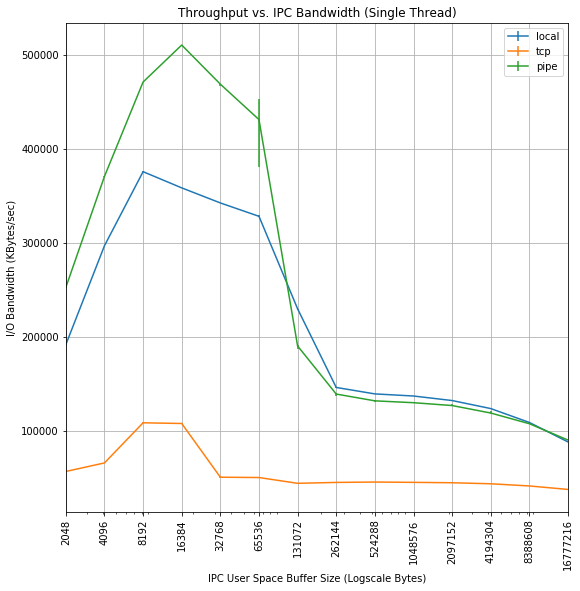

In [4]:
BUF_START = 512
#BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(8, 16)] # Start from 128KB
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(2, 16)]
TOT_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)
RUNS = 12
EXE="ipc/ipc-static"
FLAGS=""

MODE = "1thread"
IPC= "local"
local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS, xlabel='IPC User Space Buffer Size (Bytes)', ylabel='I/O Bandwidth (KBytes/sec)', label=IPC, title = "Throughput vs. IPC Bandwidth (Single Thread)")

IPC= "tcp"
tcp = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in tcp]), RUNS, label=IPC)

IPC= "pipe"
pipe = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
saveas = genfilename(EXE, MODE, "all", RUNS, FLAGS, suffix = "vary_buffer")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in pipe]), RUNS, axis = p, label=IPC, save = True, save_name = saveas)

p.legend(["local", "tcp", "pipe"])

## 2thread

	 ==> Running ipc/ipc-static
		 ==> local across 2thread
			2048 bytes 16777216 bytes: 95297.87 KBytes/sec
			4096 bytes 16777216 bytes: 160380.05 KBytes/sec
			8192 bytes 16777216 bytes: 232402.97 KBytes/sec
			16384 bytes 16777216 bytes: 238813.05 KBytes/sec
			32768 bytes 16777216 bytes: 236280.79 KBytes/sec
			65536 bytes 16777216 bytes: 204330.94 KBytes/sec
			131072 bytes 16777216 bytes: 147280.48 KBytes/sec
			262144 bytes 16777216 bytes: 110842.47 KBytes/sec
			524288 bytes 16777216 bytes: 106731.01 KBytes/sec
			1048576 bytes 16777216 bytes: 106818.27 KBytes/sec
			2097152 bytes 16777216 bytes: 102398.05 KBytes/sec
			4194304 bytes 16777216 bytes: 97497.46 KBytes/sec
			8388608 bytes 16777216 bytes: 87722.27 KBytes/sec
			16777216 bytes 16777216 bytes: 73150.92 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> tcp across 2thread
			2048 bytes 16777216 bytes: 57079.95 KBytes/sec
			4096 bytes 16777216 bytes: 89771.40 KBytes/sec
			8192 bytes 16777216 bytes: 96108.77 KBytes/sec
			

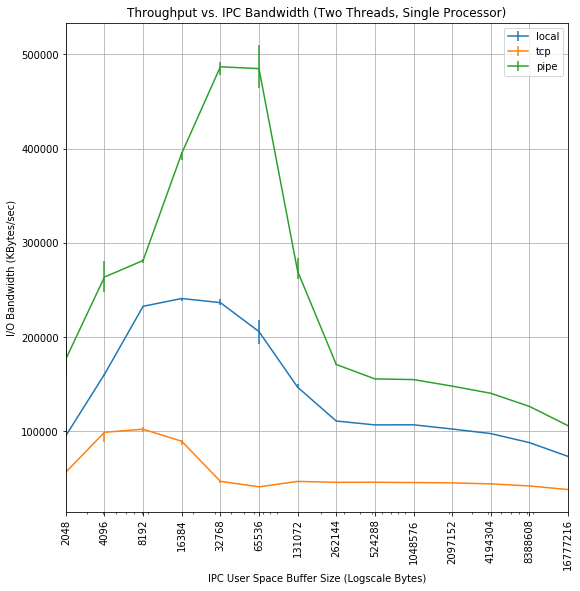

In [42]:
BUF_START = 512
#BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(8, 16)] # Start from 128KB
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(2, 16)]
TOT_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)
RUNS = 12
EXE="ipc/ipc-static"
FLAGS=""

MODE = "2thread"
IPC= "local"
local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS, xlabel='IPC User Space Buffer Size (Bytes)', ylabel='I/O Bandwidth (KBytes/sec)', label=IPC, title = "Throughput vs. IPC Bandwidth (Two Threads, Single Processor)")

IPC= "tcp"
tcp = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in tcp]), RUNS, label=IPC)

IPC= "pipe"
pipe = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
saveas = genfilename(EXE, MODE, "all", RUNS, FLAGS, suffix = "vary_buffer")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in pipe]), RUNS, axis = p, label=IPC, save = True, save_name = saveas)

p.legend(["local", "tcp", "pipe"])

## 2proc

	 ==> Running ipc/ipc-static
		 ==> local across 2proc
			2048 bytes 16777216 bytes: 68309.36 KBytes/sec
			4096 bytes 16777216 bytes: 122083.42 KBytes/sec
			8192 bytes 16777216 bytes: 189234.16 KBytes/sec
			16384 bytes 16777216 bytes: 201378.98 KBytes/sec
			32768 bytes 16777216 bytes: 199646.60 KBytes/sec
			65536 bytes 16777216 bytes: 182350.94 KBytes/sec
			131072 bytes 16777216 bytes: 134707.95 KBytes/sec
			262144 bytes 16777216 bytes: 107579.86 KBytes/sec
			524288 bytes 16777216 bytes: 105244.86 KBytes/sec
			1048576 bytes 16777216 bytes: 103186.66 KBytes/sec
			2097152 bytes 16777216 bytes: 99643.32 KBytes/sec
			4194304 bytes 16777216 bytes: 93844.68 KBytes/sec
			8388608 bytes 16777216 bytes: 83423.50 KBytes/sec
			16777216 bytes 16777216 bytes: 67845.97 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> tcp across 2proc
			2048 bytes 16777216 bytes: 54598.31 KBytes/sec
			4096 bytes 16777216 bytes: 76518.20 KBytes/sec
			8192 bytes 16777216 bytes: 91107.97 KBytes/sec
			16384

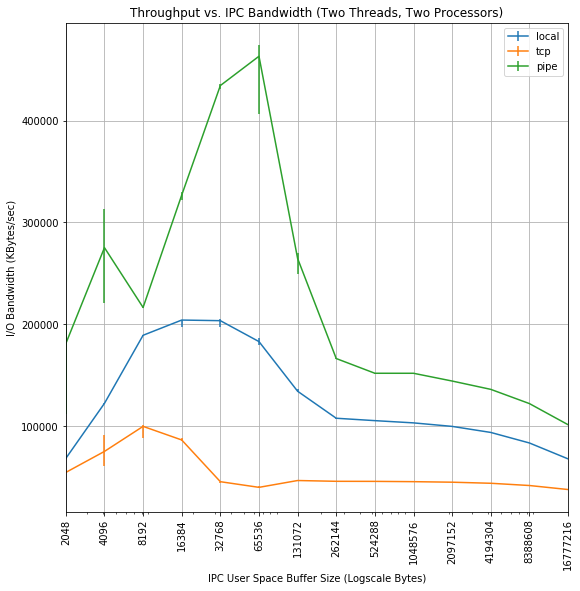

In [43]:
BUF_START = 512
#BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(8, 16)] # Start from 128KB
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(2, 16)]
TOT_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)
RUNS = 12
EXE="ipc/ipc-static"
FLAGS=""

MODE = "2proc"
IPC= "local"
local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS, xlabel='IPC User Space Buffer Size (Bytes)', ylabel='I/O Bandwidth (KBytes/sec)', label=IPC, title = "Throughput vs. IPC Bandwidth (Two Threads, Two Processors)")

IPC= "tcp"
tcp = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in tcp]), RUNS, label=IPC)

IPC= "pipe"
pipe = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
saveas = genfilename(EXE, MODE, "all", RUNS, FLAGS, suffix = "vary_buffer")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in pipe]), RUNS, axis = p, label=IPC, save = True, save_name = saveas)

p.legend(["local", "tcp", "pipe"])

# Match buffer size

## 1thread

### socket

	 ==> Running ipc/ipc-static
		 ==> tcp across 1thread
			32768 bytes 16777216 bytes: 12.36 KBytes/sec
			65536 bytes 16777216 bytes: 54491.12 KBytes/sec
			131072 bytes 16777216 bytes: 63258.33 KBytes/sec
			262144 bytes 16777216 bytes: 65953.79 KBytes/sec
			524288 bytes 16777216 bytes: 68642.05 KBytes/sec
			1048576 bytes 16777216 bytes: 68785.75 KBytes/sec
			2097152 bytes 16777216 bytes: 67364.43 KBytes/sec
			4194304 bytes 16777216 bytes: 63947.47 KBytes/sec
			8388608 bytes 16777216 bytes: 57948.20 KBytes/sec
			16777216 bytes 16777216 bytes: 49010.19 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> tcp across 1thread
			32768 bytes 16777216 bytes: 49729.92 KBytes/sec
			65536 bytes 16777216 bytes: 49894.41 KBytes/sec
			131072 bytes 16777216 bytes: 44141.87 KBytes/sec
			262144 bytes 16777216 bytes: 45007.22 KBytes/sec
			524288 bytes 16777216 bytes: 45504.80 KBytes/sec
			1048576 bytes 16777216 bytes: 45115.54 KBytes/sec
			2097152 bytes 16777216 bytes: 44737.71 KBytes/sec
			41

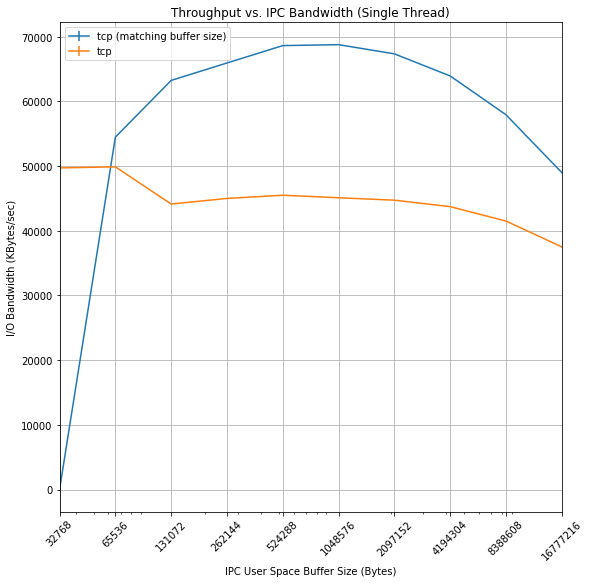

In [5]:
BUF_START = 512
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(6, 16)]
TOT_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)
RUNS = 12
EXE="ipc/ipc-static"
MODE = "1thread"
IPC= "tcp"

FLAGS="-s"
tcp = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in tcp]), RUNS, xlabel='IPC User Space Buffer Size (Bytes)', ylabel='I/O Bandwidth (KBytes/sec)', label=IPC, title = "Throughput vs. IPC Bandwidth (Single Thread)")

FLAGS=""
tcp = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
saveas = genfilename(EXE, MODE, "tcp", RUNS, FLAGS)
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in tcp]), RUNS, axis = p, label=IPC, save = True, save_name = saveas)

p.legend(["tcp (matching buffer size)", "tcp"])

### socketpair

	 ==> Running ipc/ipc-static
		 ==> local across 1thread
			32768 bytes 16777216 bytes: 379237.70 KBytes/sec
			65536 bytes 16777216 bytes: 291283.85 KBytes/sec
			131072 bytes 16777216 bytes: 117892.48 KBytes/sec
			262144 bytes 16777216 bytes: 90620.76 KBytes/sec
			524288 bytes 16777216 bytes: 86158.76 KBytes/sec
			1048576 bytes 16777216 bytes: 83269.06 KBytes/sec
			2097152 bytes 16777216 bytes: 80579.38 KBytes/sec
			4194304 bytes 16777216 bytes: 75681.39 KBytes/sec
			8388608 bytes 16777216 bytes: 66639.35 KBytes/sec
			16777216 bytes 16777216 bytes: 55267.14 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 1thread
			32768 bytes 16777216 bytes: 332581.98 KBytes/sec
			65536 bytes 16777216 bytes: 319091.39 KBytes/sec
			131072 bytes 16777216 bytes: 224561.92 KBytes/sec
			262144 bytes 16777216 bytes: 145743.08 KBytes/sec
			524288 bytes 16777216 bytes: 139212.10 KBytes/sec
			1048576 bytes 16777216 bytes: 136662.50 KBytes/sec
			2097152 bytes 16777216 bytes: 131991.81

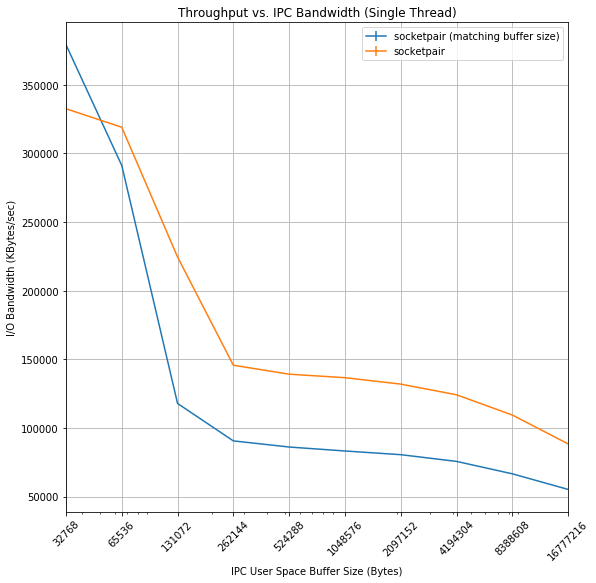

In [ ]:
BUF_START = 512
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(6, 16)]
TOT_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)
RUNS = 12
EXE="ipc/ipc-static"
MODE = "1thread"
IPC= "local"

FLAGS="-s"
local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS, xlabel='IPC User Space Buffer Size (Bytes)', ylabel='I/O Bandwidth (KBytes/sec)', label=IPC, title = "Throughput vs. IPC Bandwidth (Single Thread)")

FLAGS=""
local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
saveas = genfilename(EXE, MODE, "local", RUNS, FLAGS)
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS, axis = p, label=IPC, save = True, save_name = saveas)

p.legend(["socketpair (matching buffer size)", "socketpair"])

## 2thread

	 ==> Running ipc/ipc-static
		 ==> tcp across 2thread
			32768 bytes 16777216 bytes: 12.36 KBytes/sec
			65536 bytes 16777216 bytes: 48508.01 KBytes/sec
			131072 bytes 16777216 bytes: 63423.84 KBytes/sec
			262144 bytes 16777216 bytes: 64242.33 KBytes/sec
			524288 bytes 16777216 bytes: 67068.19 KBytes/sec
			1048576 bytes 16777216 bytes: 67908.76 KBytes/sec
			2097152 bytes 16777216 bytes: 66310.15 KBytes/sec
			4194304 bytes 16777216 bytes: 63192.42 KBytes/sec
			8388608 bytes 16777216 bytes: 57792.02 KBytes/sec
			16777216 bytes 16777216 bytes: 48779.29 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> tcp across 2thread
			32768 bytes 16777216 bytes: 46785.21 KBytes/sec
			65536 bytes 16777216 bytes: 39937.72 KBytes/sec
			131072 bytes 16777216 bytes: 45701.27 KBytes/sec
			262144 bytes 16777216 bytes: 44961.86 KBytes/sec
			524288 bytes 16777216 bytes: 45237.77 KBytes/sec
			1048576 bytes 16777216 bytes: 45092.94 KBytes/sec
			2097152 bytes 16777216 bytes: 44440.37 KBytes/sec
			41

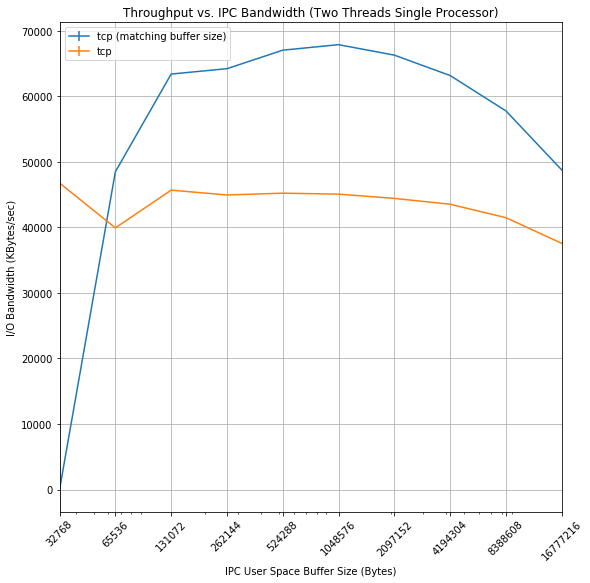

In [4]:
BUF_START = 512
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(6, 16)]
TOT_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)
RUNS = 12
EXE="ipc/ipc-static"
MODE = "2thread"
IPC= "tcp"

FLAGS="-s"
tcp = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in tcp]), RUNS, xlabel='IPC User Space Buffer Size (Bytes)', ylabel='I/O Bandwidth (KBytes/sec)', label=IPC, title = "Throughput vs. IPC Bandwidth (Two Threads Single Processor)")

FLAGS=""
tcp = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
saveas = genfilename(EXE, MODE, "tcp", RUNS, FLAGS)
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in tcp]), RUNS, axis = p, label=IPC, save = True, save_name = saveas)

p.legend(["tcp (matching buffer size)", "tcp"])

	 ==> Running ipc/ipc-static
		 ==> local across 2thread
			32768 bytes 16777216 bytes: 334935.84 KBytes/sec
			65536 bytes 16777216 bytes: 211198.98 KBytes/sec
			131072 bytes 16777216 bytes: 110117.38 KBytes/sec
			262144 bytes 16777216 bytes: 88566.78 KBytes/sec
			524288 bytes 16777216 bytes: 85071.79 KBytes/sec
			1048576 bytes 16777216 bytes: 82768.69 KBytes/sec
			2097152 bytes 16777216 bytes: 80280.99 KBytes/sec
			4194304 bytes 16777216 bytes: 75747.90 KBytes/sec
			8388608 bytes 16777216 bytes: 67193.54 KBytes/sec
			16777216 bytes 16777216 bytes: 55315.78 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 2thread
			32768 bytes 16777216 bytes: 251762.49 KBytes/sec
			65536 bytes 16777216 bytes: 232401.43 KBytes/sec
			131072 bytes 16777216 bytes: 161163.41 KBytes/sec
			262144 bytes 16777216 bytes: 119748.21 KBytes/sec
			524288 bytes 16777216 bytes: 116961.32 KBytes/sec
			1048576 bytes 16777216 bytes: 115553.34 KBytes/sec
			2097152 bytes 16777216 bytes: 105988.87

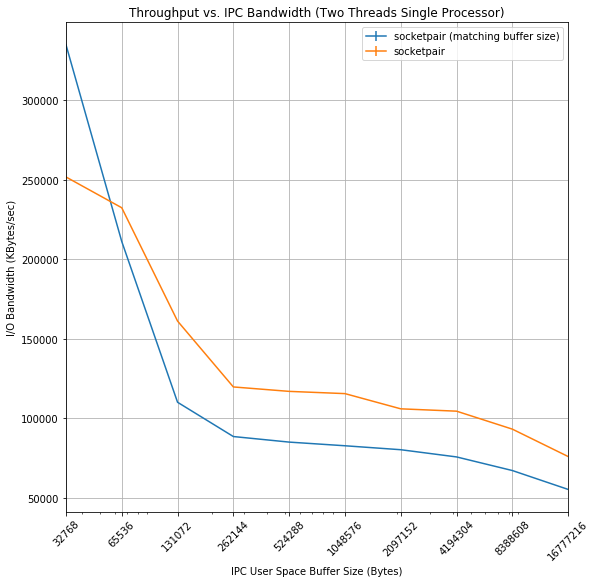

In [5]:
BUF_START = 512
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(6, 16)]
TOT_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)
RUNS = 12
EXE="ipc/ipc-static"
MODE = "2thread"
IPC= "local"

FLAGS="-s"
local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS, xlabel='IPC User Space Buffer Size (Bytes)', ylabel='I/O Bandwidth (KBytes/sec)', label=IPC, title = "Throughput vs. IPC Bandwidth (Two Threads Single Processor)")

FLAGS=""
local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
saveas = genfilename(EXE, MODE, "local", RUNS, FLAGS)
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS, axis = p, label=IPC, save = True, save_name = saveas)

p.legend(["socketpair (matching buffer size)", "socketpair"])

## 2proc

### tcp

	 ==> Running ipc/ipc-static
		 ==> tcp across 2proc
			32768 bytes 16777216 bytes: 12.36 KBytes/sec
			65536 bytes 16777216 bytes: 48239.04 KBytes/sec
			131072 bytes 16777216 bytes: 62931.41 KBytes/sec
			262144 bytes 16777216 bytes: 63869.48 KBytes/sec
			524288 bytes 16777216 bytes: 67024.97 KBytes/sec
			1048576 bytes 16777216 bytes: 67669.40 KBytes/sec
			2097152 bytes 16777216 bytes: 66063.50 KBytes/sec
			4194304 bytes 16777216 bytes: 62830.61 KBytes/sec
			8388608 bytes 16777216 bytes: 57490.80 KBytes/sec
			16777216 bytes 16777216 bytes: 48425.25 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> tcp across 2proc
			32768 bytes 16777216 bytes: 44252.38 KBytes/sec
			65536 bytes 16777216 bytes: 38986.70 KBytes/sec
			131072 bytes 16777216 bytes: 45322.90 KBytes/sec
			262144 bytes 16777216 bytes: 45178.93 KBytes/sec
			524288 bytes 16777216 bytes: 45228.99 KBytes/sec
			1048576 bytes 16777216 bytes: 44974.44 KBytes/sec
			2097152 bytes 16777216 bytes: 44337.99 KBytes/sec
			419430

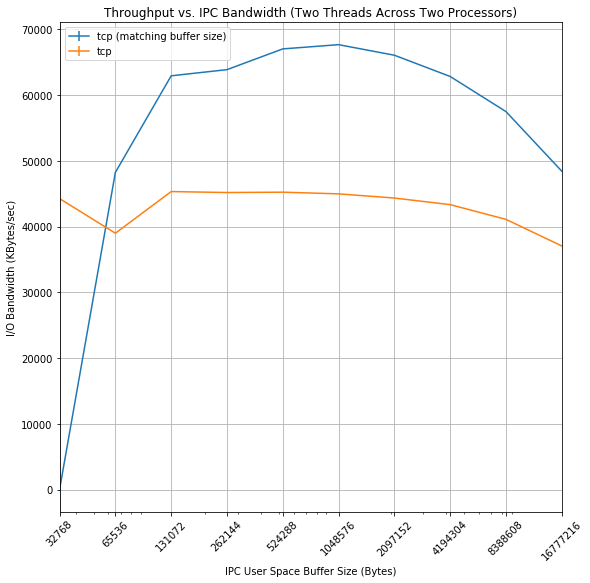

In [6]:
BUF_START = 512
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(6, 16)]
TOT_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)
RUNS = 12
EXE="ipc/ipc-static"
MODE = "2proc"
IPC= "tcp"

FLAGS="-s"
tcp = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in tcp]), RUNS, xlabel='IPC User Space Buffer Size (Bytes)', ylabel='I/O Bandwidth (KBytes/sec)', label=IPC, title = "Throughput vs. IPC Bandwidth (Two Threads Across Two Processors)")

FLAGS=""
tcp = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
saveas = genfilename(EXE, MODE, "tcp", RUNS, FLAGS)
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in tcp]), RUNS, axis = p, label=IPC, save = True, save_name = saveas)

p.legend(["tcp (matching buffer size)", "tcp"])

### socketpair

In [ ]:
BUF_START = 512
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(6, 16)]
TOT_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)
RUNS = 12
EXE="ipc/ipc-static"
MODE = "2proc"
IPC= "local"

FLAGS="-s"
local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS, xlabel='IPC User Space Buffer Size (Bytes)', ylabel='I/O Bandwidth (KBytes/sec)', label=IPC, title = "Throughput vs. IPC Bandwidth (Two Threads Across Two Processors)")

FLAGS=""
local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
saveas = genfilename(EXE, MODE, "local", RUNS, FLAGS)
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS, axis = p, label=IPC, save = True, save_name = saveas)

p.legend(["socketpair (matching buffer size)", "socketpair"])

# Notes

Investigation of IPC syscalls such as pipe(2) and socket(2). read(2) and write(2) can be performed on sockets and pipes and allow for partial reads and writes. This implies that it is possible for only a subset of a requested buffer size to be read or written. Possible causes are size limits of in-kernel IPC buffers or use of non-blocking I/O. Input and output bytes both need to be considered during benchmarking performance of IPC syscalls.

Links:
* https://www.freebsd.org/cgi/man.cgi?query=socket&sektion=2
* https://www.freebsd.org/cgi/man.cgi?pipe(2)
* https://wiki.freebsd.org/NetworkPerformanceTuning
* https://wiki.freebsd.org/BenchmarkAdvice

Benchmark:
* Set up IPC endpoints (using pipe(2) or socket(2))
* Transfer bytes from a user-space buffer using read(2)/write(2)
  * ! there is no guarantee for all bytes to be transferred however
* Modes of rx/tx operations are:
  * within single thread
  * between pair of threads in same process
  * between threads in two different processes
* Time is measured via clock_gettime(2)
* Both statically and dynamically linked version available

* -i: IPC object type (pipe, local i.e. socketpair(2), tcp i.e. socket(2))
* -t: total size of I/O file | default: 16777216
* -b: user-space IPC buffer size (bytes) | default: 131072
* 1thread, 2thread, 2proc

Testsuite:
* 1st thread/proc is receiver
* 2nd thread/proc is sender
* Sender writes timestamp to shared memory before sending bytes
  * sender_argument.sa_starttime
* Sender:
  * call write(2) with buffersize or remaining bytes to write (whichever is lower)
  * repeat writes until total I/O size is reached
* Receiver:
  * call read(2) until total I/O size has been reached
* Multiple Processes/Threads:
  * Create page (mmap(2)) for sender_argument struct
  * Set inheritance property (minherit(2)) such that the address space of the page can be shared between parent and child
  * Receive or send depending on pid
  * Return time difference
* Single thread:
  * Set non-blocking I/O flags on input file descriptors (O_NONBLOCKING from pipe(2))
  * Perform read and write in same iteration until total I/O size is reached
    * In the first iteration of the benchmark only a read can be performed unless we block because the first read failed
  * One of read or write is definitely performed at each iteration (block until rx or tx is ready if necessary (using select(2))
  * Return time of I/O loop
* Main:
  * Allocate IPC object: tcp socket, pipe, local socket
  * Prepare IPC buffer sizes if necessary
  * fsync(2) and sleep if necessary
  * Start benchmark modes
  * Print output if necessary

Source References:
* High performance pipe implementation: sys/kern/sys_pipe.c

# Scratch

In [99]:
BUF_START = 512
#BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(8, 16)] # Start from 128KB
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(2, 16)]
TOT_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)
RUNS = 5
EXE="ipc/ipc-static"
PMC="axi"
FLAGS="-P {}".format(PMC)

MODE = "1thread"
IPC= "pipe"
pipe = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES, pmc = PMC)

	 ==> Running ipc/ipc-static
		 ==> pipe across 1thread
			2048 bytes 16777216 bytes: 156253.08 KBytes/sec
			4096 bytes 16777216 bytes: 194391.78 KBytes/sec
			8192 bytes 16777216 bytes: 219592.60 KBytes/sec
			16384 bytes 16777216 bytes: 227142.54 KBytes/sec
			32768 bytes 16777216 bytes: 218141.14 KBytes/sec
			65536 bytes 16777216 bytes: 200300.44 KBytes/sec
			131072 bytes 16777216 bytes: 126954.18 KBytes/sec
			262144 bytes 16777216 bytes: 104709.88 KBytes/sec
			524288 bytes 16777216 bytes: 100099.49 KBytes/sec
			1048576 bytes 16777216 bytes: 97941.17 KBytes/sec
			2097152 bytes 16777216 bytes: 97401.44 KBytes/sec
			4194304 bytes 16777216 bytes: 92793.62 KBytes/sec
			8388608 bytes 16777216 bytes: 85737.93 KBytes/sec
			16777216 bytes 16777216 bytes: 73958.01 KBytes/sec


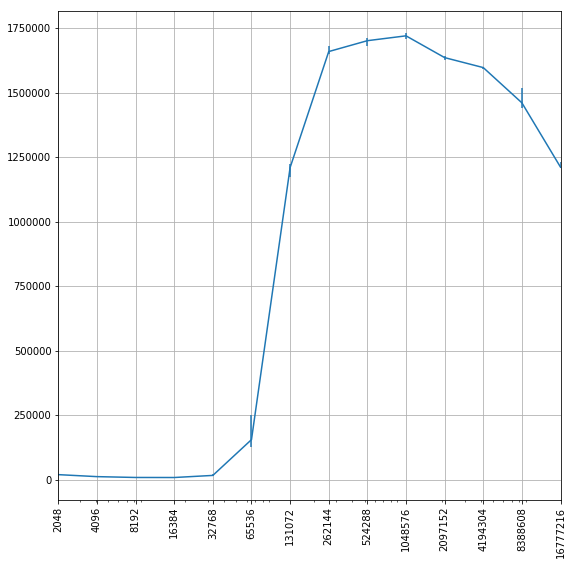

In [100]:
p = graph(BUFFER_SIZES, flatten([item['axi_read'] for item in pipe]), RUNS, label=IPC)

## Initial PMC observations

* axi_reads increase at 32KB for **pipe 1thread** which coincides with the bandwidth inflection point